In [22]:
####### Imports and plotting utils definitions

import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import LambdaCDM
from astropy.visualization import (ImageNormalize, MinMaxInterval, SqrtStretch)
from astropy.wcs import WCS
import matplotlib
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import colors
from colormaps import spectral
from matplotlib.colors import ColorConverter
import warnings
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from astropy import units as u
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
 
# Color map
cb_spec, cb_spec_r = spectral()
cb_spec.set_bad('white')
 
# Utilities
def str_to_pixel(fitsfile):
    """
    Changes the units from the FHD standard of Jy/str to Jy/pixel given 
    the typical pixel size of a 2048x2048 full sky uv-plane
    """
    my_cosmo = LambdaCDM(67.8, 0.308, 0.692)
    str_to_pixel = (0.0559529*(np.pi/180))**2   
    str_to_beam = 2.1614375e-06
    data, hdr = fits.getdata(fitsfile, header=True)
    # Set missing data to nans to become white
    data[data==0] = np.nan
    fits.writeto(fitsfile.replace('.fits','.beam.fits'),\
        data[:,:]*str_to_pixel, header=hdr, overwrite=True)
    
    return fitsfile.replace('.fits','.beam.fits')

def get_fitsinfo(fitsfile):
    """
    Extracts data and header information (metadata) from fits file
    fitsfile: Input fitsfile
    """
    data, hdr = fits.getdata(fitsfile, header=True)
    data = data.squeeze()
    freq = 182. #hdr ['CRVAL3']
    #nxaxis = hdr['NAXIS1']
    #nyaxis = hdr['NAXIS2']
    return {'data':data, 'hdr':hdr, 'freq':freq} #, 'nxaxis':nxaxis, 'nyaxis':nyaxis}

def get_radec(fitsfile):
    _info = get_fitsinfo(fitsfile)
    hdr= _info['hdr']
    
    naxis1 = hdr['NAXIS1']
    naxis2 = hdr['NAXIS2']
    x = np.linspace(1, naxis1, naxis1)
    y = np.linspace(1, naxis2, naxis2)
    xx, yy = np.meshgrid(x, y)
    
    ### vstack: Stack arrays in sequence vertically (row wise).
    ## a = np.array([1, 2, 3])
    ## b = np.array([4, 5, 6])
    ## np.vstack((a,b))
    ## array([[1, 2, 3],
    ##       [4, 5, 6]])
    ### T: transpose
    ### reshape(-1): reshape to one dimension
    pixargs = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
    
    wcs = WCS(fitsfile)
    
    if wcs.has_spectral:
        freq = np.copy(xx.reshape(-1))
        freq[:] = 1
        pixargs = np.vstack([xx.reshape(-1), yy.reshape(-1), freq, freq]).T
        world = wcs.all_pix2world(pixargs, 1)
    else:
        pixargs = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
        world = wcs.all_pix2world(pixargs, 1)
    
    ra = world[:,0].reshape(naxis1,naxis1)
    dec = world[:,1].reshape(naxis1,naxis1)
    
    return ra, dec


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


RMS of the zoomed portion: 0.19441962507712368


/var/folders/ff/f5b5jg4d1fx39nbpzht9mzzm0000gp/T/ipykernel_71618/2618639676.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


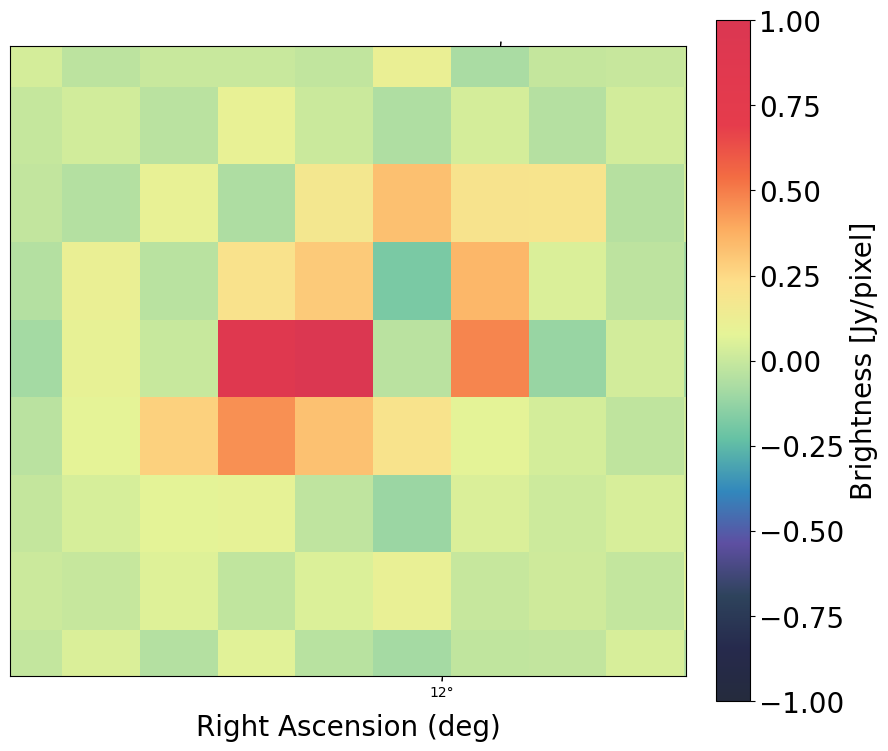

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


RMS of the zoomed portion: 0.19315589137225778


/var/folders/ff/f5b5jg4d1fx39nbpzht9mzzm0000gp/T/ipykernel_71618/2618639676.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


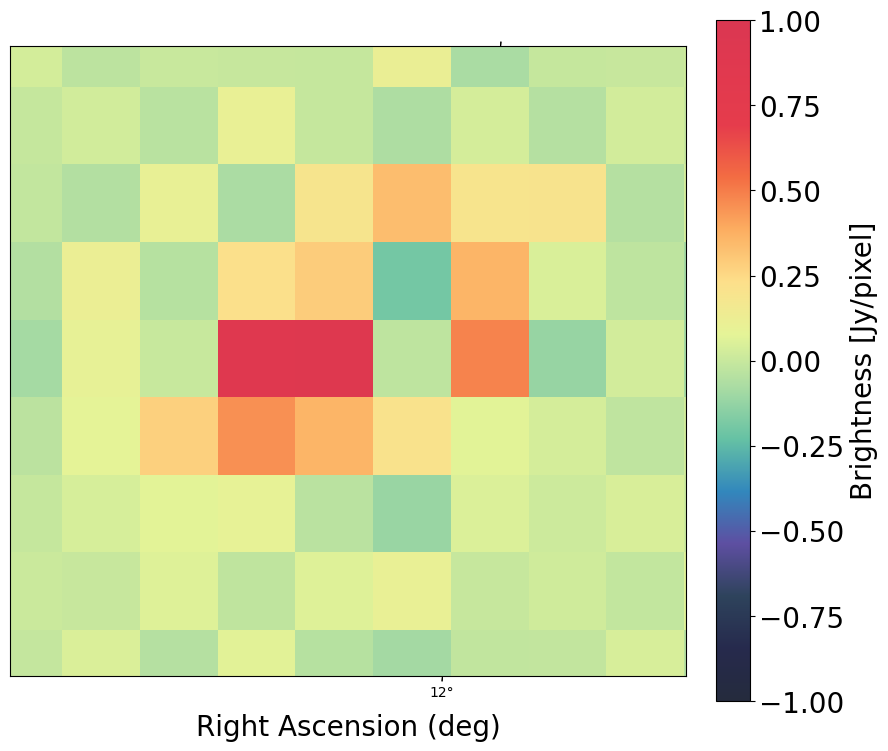

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


RMS of the zoomed portion: 0.193063612229525


/var/folders/ff/f5b5jg4d1fx39nbpzht9mzzm0000gp/T/ipykernel_71618/2618639676.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


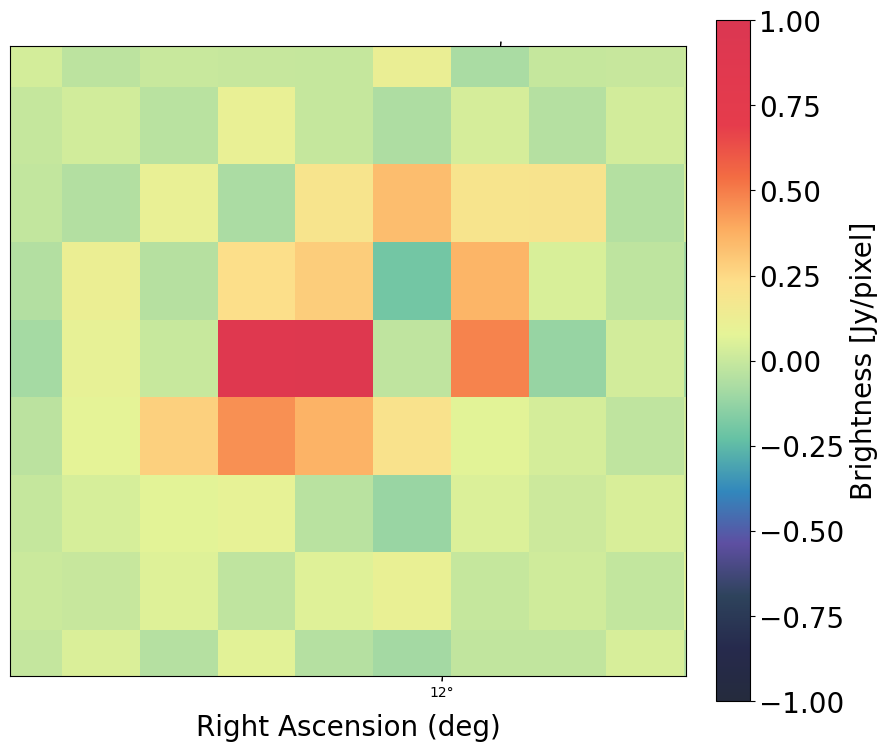

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


RMS of the zoomed portion: 0.25872111341676196


/var/folders/ff/f5b5jg4d1fx39nbpzht9mzzm0000gp/T/ipykernel_71618/2618639676.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


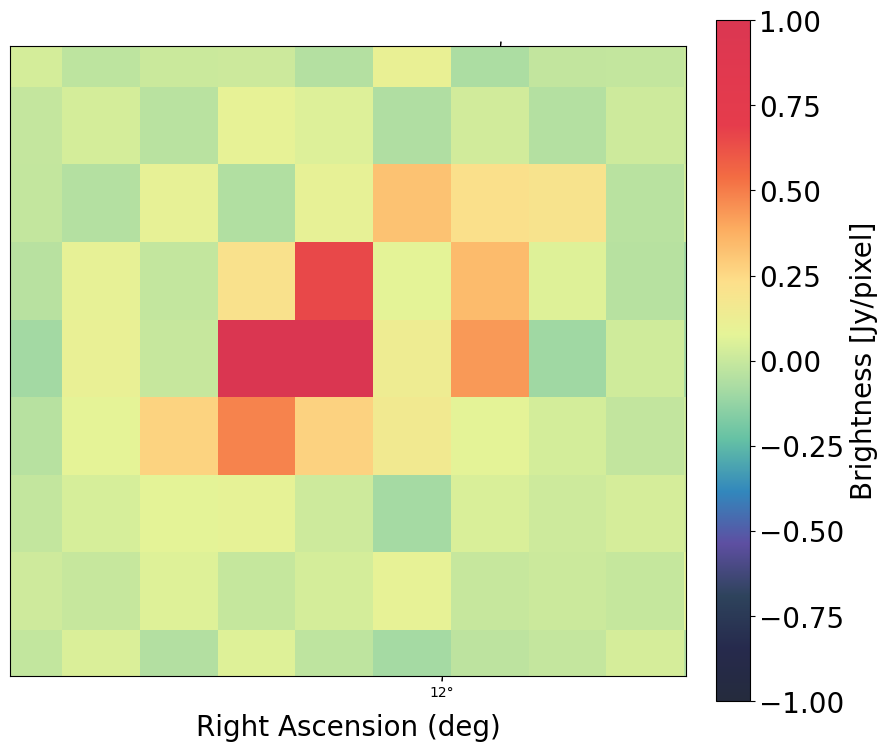

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


RMS of the zoomed portion: 0.3754952064707732


/var/folders/ff/f5b5jg4d1fx39nbpzht9mzzm0000gp/T/ipykernel_71618/2618639676.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


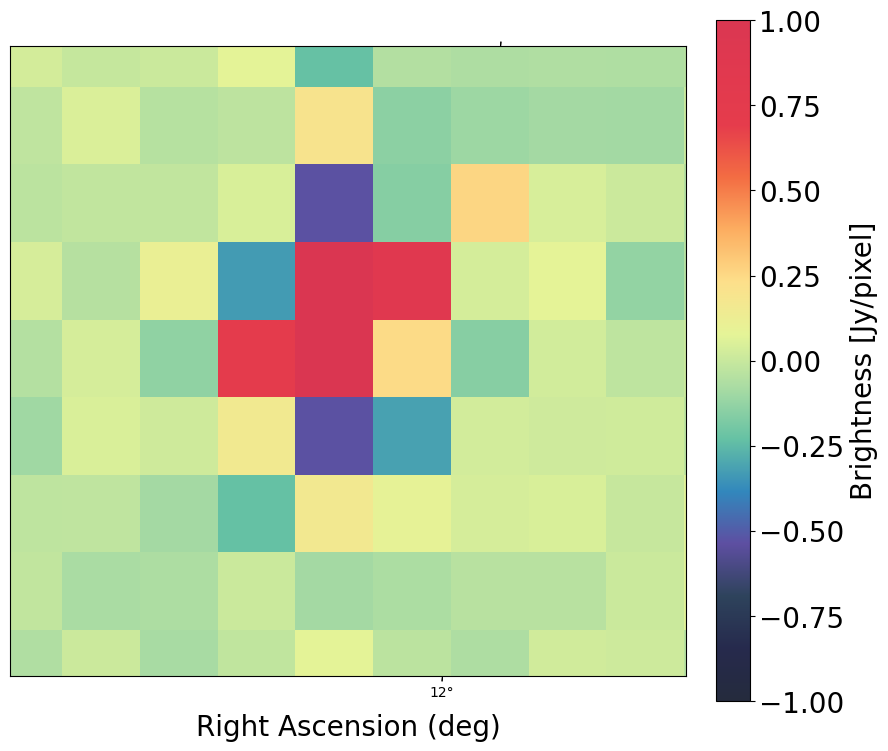

In [28]:
####### 
####### 


def plot_residuals(fitsfile_pre, cmap=cb_spec, vmin=None, vmax=None, imsz=None, width=None, \
                             savefig=False, fontsize=None, figname=''):
    

    fitsfile = str_to_pixel(fitsfile_pre)
    _info = get_fitsinfo(fitsfile)
    hdr = _info['hdr']
    data = _info['data']

    _info_pre = get_fitsinfo(fitsfile_pre)
    data_pre = _info_pre['data']

    wcs = WCS(hdr)
    
    fig = plt.figure(figsize=(21, 21))
    ax1 = fig.add_subplot(1, 2, 1, projection=wcs)

    vmin = -1
    vmax = 1
    ra_range = (11.65, 12.15)
    dec_range = (-25.55, -25.05)
    
    #norm = ImageNormalize(data, interval=MinMaxInterval(), stretch=SqrtStretch())
    im = ax1.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    #im = ax1.imshow(data, cmap=cmap, norm=norm, origin='lower')
 
    ax1.set_xlabel('Right Ascension (deg)', fontsize=fontsize)
    ax1.set_ylabel('Declination (deg)', fontsize=fontsize)
    ax1.coords[0].set_major_formatter('dd')
    ax1.coords[1].set_major_formatter('dd')

    if ra_range and dec_range:
        ra_min, ra_max = ra_range
        dec_min, dec_max = dec_range
        x_min, y_min = wcs.world_to_pixel_values(ra_min, dec_min)
        x_max, y_max = wcs.world_to_pixel_values(ra_max, dec_max)
        ax1.set_xlim(x_min, x_max)
        ax1.set_ylim(y_min, y_max)

        # Extract the zoomed portion of the data
        x_min, x_max = int(x_min), int(x_max)
        y_min, y_max = int(y_min), int(y_max)
        zoomed_data = data[y_min:y_max, x_min:x_max]
        
        # Calculate the RMS of the zoomed portion
        rms = np.sqrt(np.mean(zoomed_data**2))
        print(f'RMS of the zoomed portion: {rms}')
    
    cbar = fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label(r'Brightness [Jy/pixel]', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()



dir_plt = '/Users/z3543600/tmp/fits_res/'
files = [dir_plt + '1088285600_uniform_Residual_I_8.fits',\
        dir_plt + '1088285600_uniform_Residual_I_16.fits',\
        dir_plt + '1088285600_uniform_Residual_I_24.fits',\
        dir_plt + '1088285600_uniform_Residual_I_40.fits',\
        dir_plt + '1088285600_uniform_Residual_I_orig.fits']

i=0
for file in files:
    file_noext = os.path.splitext(file)[0] + str(i)
    plot_residuals(file, \
                  vmax=100,vmin=-100,imsz=114/2, width=114, fontsize=20, savefig=False)
    i= i + 1